<a href="https://colab.research.google.com/github/Misha-private/Demo-repo/blob/main/MLDA_ViT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We now move to scattered-in-space observations

# 1. Imports and basic config

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# 2. IC generator and IC dataset (same as before)

In [ ]:
# ============================================
# Two-layer SW initial condition on Klein-β
# ============================================
def make_ic_sw2l_klein(
    Nx=128,
    Ny=64,
    Lx=2.0e7,     # domain length in x (m) ~ 20,000 km
    Ly=6.0e6,     # domain length in y (m) ~ 6,000 km
    g=9.81,
    H1=500.0,     # mean depth layer 1 (m)
    H2=500.0,     # mean depth layer 2 (m)
    f0=1.0e-4,    # reference Coriolis (s^-1)
    beta=2.0e-11, # beta parameter (1/(m s))
    A_bt=10.0,    # barotropic height amplitude (m)
    A_bc=20.0,    # baroclinic height amplitude (m)
    alpha=1.0,    # how strongly baroclinic the anomaly is
    R_frac=0.15,  # Gaussian radius as fraction of Lx
    noise_amp=0.05, # small velocity noise (m/s)
    seed=None,
):
    """
    Create a single initial condition for a 2-layer SW model
    on a Klein-beta rectangular channel.

    Returns:
      h1, h2, u1, v1, u2, v2  each shape (Ny, Nx)
    """
    rng = np.random.RandomState(seed)

    # --- Grid in physical space ---
    dx = Lx / Nx
    dy = Ly / Ny
    x = (np.arange(Nx) + 0.5) * dx
    y = (np.arange(Ny) + 0.5) * dy
    X, Y = np.meshgrid(x, y)  # (Ny, Nx)

    # Central latitude y0 (for f(y) if needed)
    y0 = 0.5 * Ly
    f = f0 + beta * (Y - y0)  # not used directly below, but kept for completeness

    # --- Choose Gaussian center & radius for baroclinic part ---
    x_c = rng.uniform(0.3 * Lx, 0.7 * Lx)
    y_c = rng.uniform(0.3 * Ly, 0.7 * Ly)
    R = R_frac * Lx

    # --- Barotropic anomaly (same sign in both layers) ---
    eta_bt = A_bt * np.sin(2.0 * np.pi * X / Lx) * np.sin(np.pi * Y / Ly)

    # --- Baroclinic anomaly (opposite sign in two layers) ---
    rr2 = (X - x_c) ** 2 + (Y - y_c) ** 2
    eta_bc = A_bc * np.exp(-rr2 / R**2) * np.cos(2.0 * np.pi * X / Lx)

    # Surface anomalies for each layer
    eta1 = eta_bt + alpha * eta_bc
    eta2 = eta_bt - alpha * eta_bc

    # Total layer depths (ensure positive)
    h1 = H1 + eta1
    h2 = H2 + eta2
    h1 = np.maximum(h1, 1.0)
    h2 = np.maximum(h2, 1.0)

    # --- Approximate geostrophic velocities (using constant f0) ---
    f_ref = f0

    def ddx(field):
        # Periodic in x
        return (np.roll(field, -1, axis=1) - np.roll(field, 1, axis=1)) / (2.0 * dx)

    def ddy(field):
        # "Wall" boundaries in y (Neumann)
        f_p = np.empty_like(field)
        f_m = np.empty_like(field)
        f_p[1:-1, :] = field[2:, :]
        f_m[1:-1, :] = field[:-2, :]
        f_p[0, :] = field[1, :]
        f_m[0, :] = field[0, :]
        f_p[-1, :] = field[-1, :]
        f_m[-1, :] = field[-2, :]
        return (f_p - f_m) / (2.0 * dy)

    d_eta1_dx = ddx(eta1)
    d_eta1_dy = ddy(eta1)
    d_eta2_dx = ddx(eta2)
    d_eta2_dy = ddy(eta2)

    # Geostrophic relation: u = -g/f ∂η/∂y, v = g/f ∂η/∂x
    u1 = - (g / f_ref) * d_eta1_dy
    v1 =   (g / f_ref) * d_eta1_dx
    u2 = - (g / f_ref) * d_eta2_dy
    v2 =   (g / f_ref) * d_eta2_dx

    # Small random velocity noise to break symmetry
    u1 += noise_amp * rng.randn(*u1.shape)
    v1 += noise_amp * rng.randn(*v1.shape)
    u2 += noise_amp * rng.randn(*u2.shape)
    v2 += noise_amp * rng.randn(*v2.shape)

    return h1, h2, u1, v1, u2, v2


def build_ic_dataset_sw2l(
    N_samples=200,
    Nx=128,
    Ny=64,
    base_seed=123,
):
    """
    Build a static dataset of 2-layer SW initial conditions
    on the Klein-beta plane.

    Returns:
      truth: array of shape (N_samples, 6, Ny, Nx)
             [h1, h2, u1, v1, u2, v2]
    """
    C_state = 6
    truth = np.zeros((N_samples, C_state, Ny, Nx), dtype=np.float32)

    for i in range(N_samples):
        seed = base_seed + i  # different seed for each IC

        # Optionally randomize amplitudes per sample
        A_bt = 10.0 * (0.5 + np.random.rand())
        A_bc = 20.0 * (0.5 + np.random.rand())

        h1, h2, u1, v1, u2, v2 = make_ic_sw2l_klein(
            Nx=Nx, Ny=Ny,
            A_bt=A_bt,
            A_bc=A_bc,
            seed=seed,
        )
        truth[i, 0] = h1
        truth[i, 1] = h2
        truth[i, 2] = u1
        truth[i, 3] = v1
        truth[i, 4] = u2
        truth[i, 5] = v2

    return truth


# Build IC dataset
truth_static = build_ic_dataset_sw2l(N_samples=200, Nx=128, Ny=64)
print("truth_static shape:", truth_static.shape)  # (N, 6, H, W)


truth_static shape: (200, 6, 64, 128)


# 3. Convert to anomalies, then build scattered-in-space observations

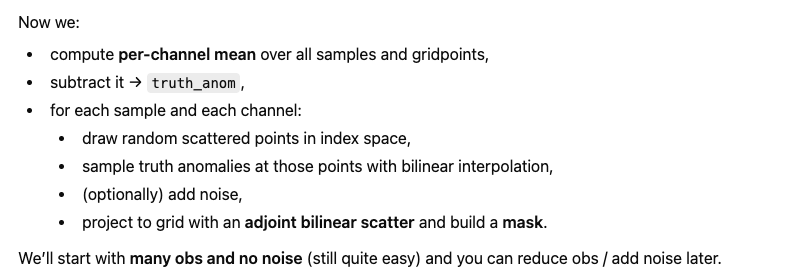

In [ ]:
# ============================================
# Convert to anomalies (per-channel global mean)
# ============================================
N, C_state, H, W = truth_static.shape

channel_means = truth_static.mean(axis=(0, 2, 3), keepdims=True)  # (1, C, 1, 1)
print("Channel means (original):", channel_means.reshape(-1))

truth_anom = truth_static - channel_means
print("Anomalies: min, max, std per channel:")
for c, name in enumerate(["h1", "h2", "u1", "v1", "u2", "v2"]):
    fld = truth_anom[:, c].ravel()
    print(f"{name}: min={fld.min():8.3f}, max={fld.max():8.3f}, std={fld.std():8.3f}")


Channel means (original): [ 4.9763181e+02  5.0236819e+02 -8.0528721e-04 -7.8636112e-05
  7.9878391e-04  2.6687256e-05]
Anomalies: min, max, std per channel:
h1: min= -30.444, max=  20.093, std=   6.892
h2: min= -19.074, max=  29.026, std=   6.845
u1: min=  -1.150, max=   1.143, std=   0.296
v1: min=  -1.427, max=   0.982, std=   0.280
u2: min=  -1.136, max=   1.127, std=   0.295
v2: min=  -1.437, max=   0.991, std=   0.279


# 3a. Bilinear sampling and adjoint scatter

In [ ]:
# ============================================
# Bilinear sampling & adjoint scatter
# ============================================
def sample_field_bilinear(field_2d, x, y):
    """
    Bilinear sampling from a 2D field on an A-grid.
    field_2d: (H, W)
    x, y: 1D arrays of fractional indices in [0, W), [0, H).
           (index-space, not meters)
    Periodic in x, clamped in y.
    """
    H, W = field_2d.shape
    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    fx = x - x0
    fy = y - y0

    x1 = (x0 + 1) % W
    y1 = np.clip(y0 + 1, 0, H - 1)
    x0 = x0 % W
    y0 = np.clip(y0, 0, H - 1)

    v00 = field_2d[y0, x0]
    v10 = field_2d[y0, x1]
    v01 = field_2d[y1, x0]
    v11 = field_2d[y1, x1]

    w00 = (1.0 - fx) * (1.0 - fy)
    w10 = fx * (1.0 - fy)
    w01 = (1.0 - fx) * fy
    w11 = fx * fy

    vals = w00 * v00 + w10 * v10 + w01 * v01 + w11 * v11
    return vals


def scatter_to_grid_adj(x, y, v, H, W, eps=1e-6):
    """
    Adjoint of bilinear interpolation (points -> grid).

    Each observation at fractional index (x,y) contributes
    to 4 surrounding grid points with bilinear weights,
    accumulating a weighted average.

    Returns:
      grid: (H,W) interpolated values
      mask: (H,W) 1 where any obs contributed, 0 otherwise
    """
    grid_sum = np.zeros((H, W), dtype=np.float32)
    grid_wgt = np.zeros((H, W), dtype=np.float32)

    x0 = np.floor(x).astype(int)
    y0 = np.floor(y).astype(int)
    fx = x - x0
    fy = y - y0

    x1 = (x0 + 1) % W
    y1 = np.clip(y0 + 1, 0, H - 1)
    x0 = x0 % W
    y0 = np.clip(y0, 0, H - 1)

    w00 = (1.0 - fx) * (1.0 - fy)
    w10 = fx * (1.0 - fy)
    w01 = (1.0 - fx) * fy
    w11 = fx * fy

    for k in range(len(v)):
        vv = v[k]
        i0, j0 = x0[k], y0[k]
        i1, j1 = x1[k], y1[k]

        grid_sum[j0, i0] += w00[k] * vv
        grid_wgt[j0, i0] += w00[k]
        grid_sum[j0, i1] += w10[k] * vv
        grid_wgt[j0, i1] += w10[k]
        grid_sum[j1, i0] += w01[k] * vv
        grid_wgt[j1, i0] += w01[k]
        grid_sum[j1, i1] += w11[k] * vv
        grid_wgt[j1, i1] += w11[k]

    grid = grid_sum / np.maximum(grid_wgt, eps)
    mask = (grid_wgt > 0.0).astype(np.float32)
    return grid, mask


# 3b. Build scattered-obs datasets

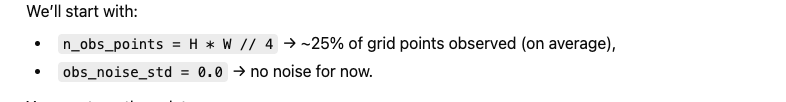

In [ ]:
# ============================================
# Build obs dataset: SCATTERED in space
# X[i] = [obs_grid (C), mask_grid (C)]
# Y[i] = truth_anom
# ============================================
def make_obs_dataset_scattered(
    truth_anom,
    n_obs_points,
    obs_noise_std=0.0,
    seed=123,
):
    """
    Given anomaly truths of shape (N, C, H, W),
    generate scattered spatial observations and
    build ViT-ready inputs/targets.

    For each sample i and channel c:
      - Draw n_obs_points random locations (x,y) in index-space
      - Sample truth_anom[i,c] at those points (bilinear)
      - Add Gaussian noise (if obs_noise_std > 0)
      - Scatter to grid + mask via adjoint bilinear

    Inputs:
      X[i] = [obs_grid (C), mask_grid (C)]  shape (2*C, H, W)
      Y[i] = truth_anom[i]                  shape (C, H, W)
    """
    rng = np.random.RandomState(seed)
    N, C, H, W = truth_anom.shape

    X = np.zeros((N, 2 * C, H, W), dtype=np.float32)
    Y = truth_anom.astype(np.float32).copy()

    for i in range(N):
        field = truth_anom[i]  # (C,H,W)

        # Random observation locations in index space
        x_obs = rng.uniform(0.0, W, size=n_obs_points)
        y_obs = rng.uniform(0.0, H, size=n_obs_points)

        obs_grid = np.zeros((C, H, W), dtype=np.float32)
        mask_grid = np.zeros((C, H, W), dtype=np.float32)

        for c in range(C):
            field_c = field[c]
            vals_clean = sample_field_bilinear(field_c, x_obs, y_obs)
            noise = obs_noise_std * rng.randn(n_obs_points)
            vals = vals_clean + noise

            g_c, m_c = scatter_to_grid_adj(x_obs, y_obs, vals, H, W)
            obs_grid[c] = g_c
            mask_grid[c] = m_c

        X[i] = np.concatenate([obs_grid, mask_grid], axis=0)

    return X, Y


# Choose obs density and noise
n_obs_points = (H * W) // 4   # ~25% of the grid
obs_noise_std = 0.0           # start with noise-free

X, Y = make_obs_dataset_scattered(
    truth_anom,
    n_obs_points=n_obs_points,
    obs_noise_std=obs_noise_std,
    seed=123,
)
print("X shape:", X.shape)  # (N, 2*C_state, H, W)
print("Y shape:", Y.shape)  # (N, C_state, H, W)


X shape: (200, 12, 64, 128)
Y shape: (200, 6, 64, 128)


### Optional: visualize obs coverage & anomalies for one sample:

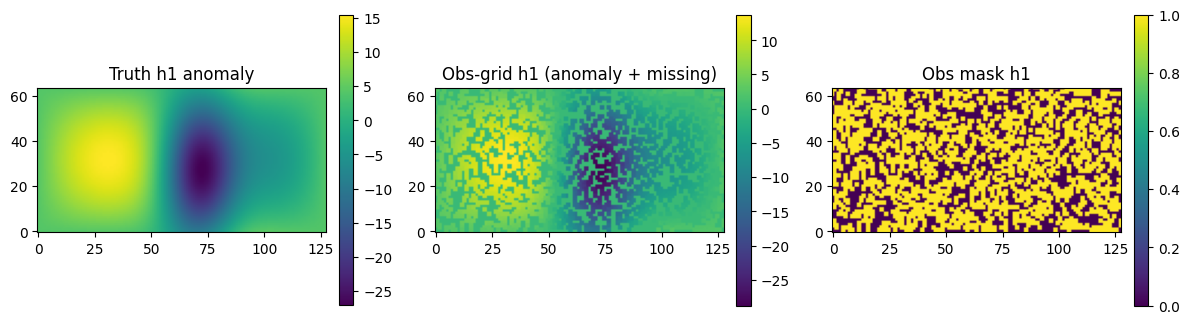

In [ ]:
i_plot = 0
h1_truth = Y[i_plot, 0]
h1_obs   = X[i_plot, 0]       # obs-grid for h1
h1_mask  = X[i_plot, C_state] # first mask channel

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

im0 = axs[0].imshow(h1_truth - h1_truth.mean(), origin="lower")
axs[0].set_title("Truth h1 anomaly")
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(h1_obs, origin="lower")
axs[1].set_title("Obs-grid h1 (anomaly + missing)")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

im2 = axs[2].imshow(h1_mask, origin="lower")
axs[2].set_title("Obs mask h1")
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


# 4. ViT model (same a before)

In [ ]:
# ============================================
# ViT-based static DA model
# ============================================
class PatchEmbed2D(nn.Module):
    def __init__(self, in_chans, embed_dim, patch_size, img_size):
        super().__init__()
        self.patch_size = patch_size
        H, W = img_size
        assert H % patch_size == 0 and W % patch_size == 0, \
            "img_size must be divisible by patch_size"
        self.Hp = H // patch_size
        self.Wp = W // patch_size
        self.proj = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )

    def forward(self, x):
        x = self.proj(x)  # (B, E, Hp, Wp)
        B, E, Hp, Wp = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        return x, (Hp, Wp)


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class MLP(nn.Module):
    def __init__(self, dim, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        hidden_dim = int(dim * mlp_ratio)
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadSelfAttention(dim, num_heads, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_ratio, drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class ViT_DA_Static(nn.Module):
    """
    ViT-based DA for a *static* 2-layer SW state:
      input:  (B, C_in, H, W)  [obs, mask]
      output: (B, C_state, H, W)  anomalies
    """
    def __init__(
        self,
        in_chans,
        out_chans,
        img_size,
        patch_size=8,
        embed_dim=128,
        depth=4,
        num_heads=4,
        mlp_ratio=4.0,
    ):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size

        self.patch_embed = PatchEmbed2D(
            in_chans=in_chans,
            embed_dim=embed_dim,
            patch_size=patch_size,
            img_size=img_size,
        )
        Hp, Wp = self.patch_embed.Hp, self.patch_embed.Wp
        self.num_patches = Hp * Wp

        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))

        self.blocks = nn.ModuleList([
            TransformerBlock(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                drop=0.0,
            ) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

        self.head_conv = nn.Sequential(
            nn.Conv2d(embed_dim, 64, kernel_size=3, padding=1),
            nn.GELU(),
            nn.Conv2d(64, out_chans, kernel_size=1),
        )

    def forward(self, x):
        B, C, H, W = x.shape
        tokens, (Hp, Wp) = self.patch_embed(x)
        tokens = tokens + self.pos_embed
        for blk in self.blocks:
            tokens = blk(tokens)
        tokens = self.norm(tokens)
        x_p = tokens.transpose(1, 2).reshape(B, -1, Hp, Wp)
        x_p = F.interpolate(
            x_p, scale_factor=self.patch_size,
            mode="bilinear", align_corners=False
        )
        out = self.head_conv(x_p)
        return out


# 5. Data loaders and training (same structure)

In [ ]:
# ============================================
# Prepare PyTorch datasets & loaders
# ============================================
X_torch = torch.from_numpy(X)  # (N, C_in, H, W)
Y_torch = torch.from_numpy(Y)  # (N, C_state, H, W)

N, C_in, H, W = X_torch.shape
C_state = Y_torch.shape[1]
print("N, C_in, C_state, H, W =", N, C_in, C_state, H, W)

idx = np.arange(N)
np.random.shuffle(idx)
n_train = int(0.8 * N)
idx_train = idx[:n_train]
idx_val   = idx[n_train:]

train_ds = TensorDataset(X_torch[idx_train], Y_torch[idx_train])
val_ds   = TensorDataset(X_torch[idx_val],   Y_torch[idx_val])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False)


# ============================================
# Model, loss, optimizer
# ============================================
model_vit = ViT_DA_Static(
    in_chans=C_in,
    out_chans=C_state,
    img_size=(H, W),
    patch_size=8,
    embed_dim=128,
    depth=4,
    num_heads=4,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model_vit.parameters(), lr=1e-4)

def eval_rmse(model, loader, device):
    model.eval()
    se_sum = 0.0
    n_vals = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            se_sum += ((out - yb) ** 2).sum().item()
            n_vals += yb.numel()
    mse = se_sum / n_vals
    return np.sqrt(mse)


# ============================================
# Training loop
# ============================================
n_epochs = 20
train_losses = []
val_rmses = []

for epoch in range(1, n_epochs + 1):
    model_vit.train()
    total_loss = 0.0
    n_samp = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        out = model_vit(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        n_samp += xb.size(0)

    train_loss = total_loss / n_samp
    val_rmse = eval_rmse(model_vit, val_loader, device)
    train_losses.append(train_loss)
    val_rmses.append(val_rmse)

    print(f"Epoch {epoch:03d} | train_loss={train_loss:.3e} | val_RMSE={val_rmse:.3e}")


N, C_in, C_state, H, W = 200 12 6 64 128
Epoch 001 | train_loss=8.549e+00 | val_RMSE=2.291e+00
Epoch 002 | train_loss=2.884e+00 | val_RMSE=1.451e+00
Epoch 003 | train_loss=1.178e+00 | val_RMSE=1.005e+00
Epoch 004 | train_loss=6.040e-01 | val_RMSE=7.595e-01
Epoch 005 | train_loss=3.791e-01 | val_RMSE=6.248e-01
Epoch 006 | train_loss=2.788e-01 | val_RMSE=5.536e-01
Epoch 007 | train_loss=2.199e-01 | val_RMSE=4.946e-01
Epoch 008 | train_loss=1.838e-01 | val_RMSE=4.523e-01
Epoch 009 | train_loss=1.580e-01 | val_RMSE=4.155e-01
Epoch 010 | train_loss=1.318e-01 | val_RMSE=3.831e-01
Epoch 011 | train_loss=1.143e-01 | val_RMSE=3.550e-01
Epoch 012 | train_loss=9.661e-02 | val_RMSE=3.265e-01
Epoch 013 | train_loss=8.423e-02 | val_RMSE=3.050e-01
Epoch 014 | train_loss=7.392e-02 | val_RMSE=2.909e-01
Epoch 015 | train_loss=6.538e-02 | val_RMSE=2.785e-01
Epoch 016 | train_loss=5.815e-02 | val_RMSE=2.580e-01
Epoch 017 | train_loss=5.392e-02 | val_RMSE=2.578e-01
Epoch 018 | train_loss=4.982e-02 | val_RM

### Optionally plot loss/RMSE curve

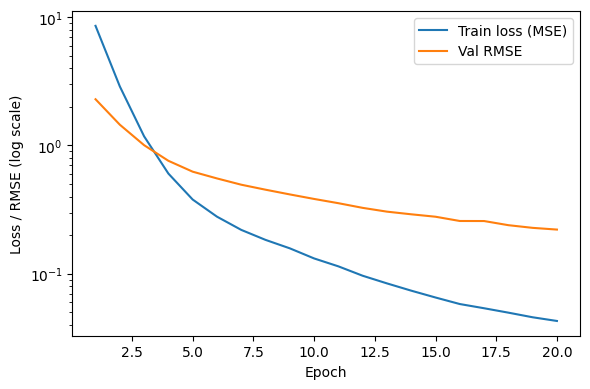

In [10]:
epochs = np.arange(1, n_epochs + 1)
plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, label="Train loss (MSE)")
plt.plot(epochs, val_rmses, label="Val RMSE")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss / RMSE (log scale)")
plt.legend()
plt.tight_layout()
plt.show()


# 6. Anomaly plots: truth vs reconstruction

In [11]:
# ============================================
# Helper: plot anomalies (field - mean) for ALL variables
# ============================================
def plot_anomalies_all_vars(data, idx=0, var_names=None, title_prefix=""):
    """
    Plot anomalies (field - spatial mean) for ALL variables
    of a single sample.

    data: np.ndarray of shape (B, C, H, W)
    idx: which sample in batch
    var_names: list of variable names of length C
    """
    sample = data[idx]  # (C, H, W)
    C, H, W = sample.shape

    if var_names is None:
        var_names = [f"var{c}" for c in range(C)]
    assert len(var_names) == C

    print(f"\n[{title_prefix}] sample idx={idx}, data.shape={data.shape}")
    fig, axs = plt.subplots(1, C, figsize=(3 * C, 3))
    if C == 1:
        axs = [axs]

    for c in range(C):
        fld = sample[c]
        print(f"{title_prefix} {var_names[c]}: min={fld.min():8.3f}, max={fld.max():8.3f}, std={fld.std():8.3f}")
        anom = fld - fld.mean()
        print(f"{title_prefix} anom {var_names[c]}: min={anom.min():8.3f}, max={anom.max():8.3f}, std={anom.std():8.3f}")

        vmax = np.max(np.abs(anom))
        if vmax == 0:
            vmax = 1e-6
        vmin, vmax = -vmax, vmax

        im = axs[c].imshow(anom, origin="lower", vmin=vmin, vmax=vmax)
        axs[c].set_title(f"{var_names[c]} anomaly ({title_prefix})")
        axs[c].set_xticks([]); axs[c].set_yticks([])
        plt.colorbar(im, ax=axs[c], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


#### Use it on a val batch


[Truth] sample idx=0, data.shape=(4, 6, 64, 128)
Truth h1: min= -13.794, max=   8.838, std=   5.099
Truth anom h1: min= -14.891, max=   7.740, std=   5.099
Truth h2: min= -11.527, max=   5.772, std=   3.898
Truth anom h2: min= -10.429, max=   6.870, std=   3.898
Truth u1: min=  -0.629, max=   0.721, std=   0.212
Truth anom u1: min=  -0.620, max=   0.730, std=   0.212
Truth v1: min=  -0.716, max=   0.688, std=   0.221
Truth anom v1: min=  -0.716, max=   0.688, std=   0.221
Truth u2: min=  -0.490, max=   0.520, std=   0.175
Truth anom u2: min=  -0.499, max=   0.512, std=   0.175
Truth v2: min=  -0.748, max=   0.423, std=   0.196
Truth anom v2: min=  -0.748, max=   0.423, std=   0.196


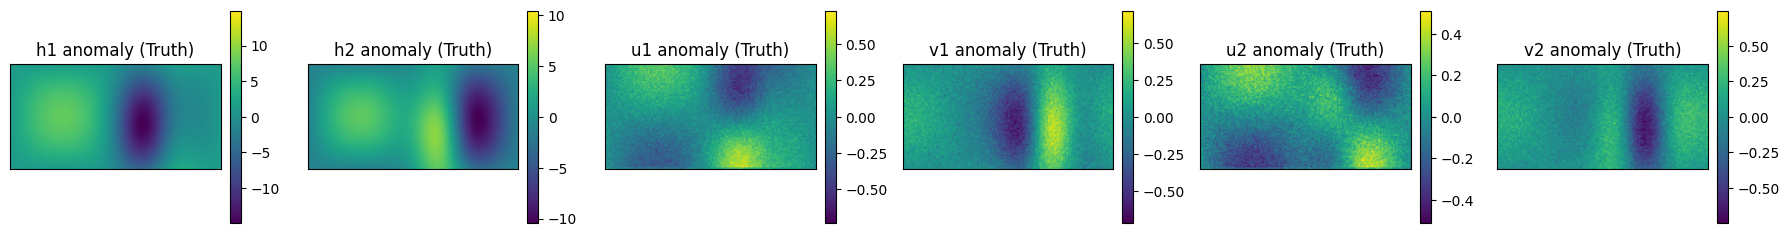


[Recon] sample idx=0, data.shape=(4, 6, 64, 128)
Recon h1: min= -13.467, max=   8.948, std=   5.048
Recon anom h1: min= -14.633, max=   7.783, std=   5.048
Recon h2: min= -10.902, max=   5.907, std=   3.838
Recon anom h2: min=  -9.816, max=   6.993, std=   3.838
Recon u1: min=  -0.491, max=   0.402, std=   0.192
Recon anom u1: min=  -0.481, max=   0.411, std=   0.192
Recon v1: min=  -0.444, max=   0.601, std=   0.173
Recon anom v1: min=  -0.457, max=   0.588, std=   0.173
Recon u2: min=  -0.314, max=   0.518, std=   0.166
Recon anom u2: min=  -0.346, max=   0.486, std=   0.166
Recon v2: min=  -0.698, max=   0.407, std=   0.194
Recon anom v2: min=  -0.722, max=   0.383, std=   0.194


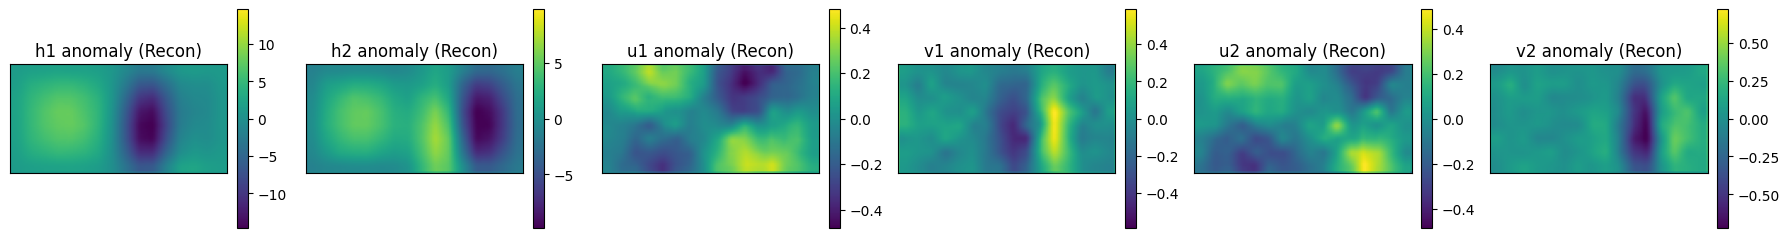


Sample RMSE (all vars, all points): 0.14255823


In [12]:
var_names = ["h1", "h2", "u1", "v1", "u2", "v2"]

model_vit.eval()
with torch.no_grad():
    xb_batch, yb_batch = next(iter(val_loader))
    xb_batch = xb_batch.to(device)
    yb_batch = yb_batch.to(device)
    y_pred_batch = model_vit(xb_batch)

y_true = yb_batch.cpu().numpy()
y_pred = y_pred_batch.cpu().numpy()

idx_example = 0

plot_anomalies_all_vars(
    data=y_true,
    idx=idx_example,
    var_names=var_names,
    title_prefix="Truth",
)

plot_anomalies_all_vars(
    data=y_pred,
    idx=idx_example,
    var_names=var_names,
    title_prefix="Recon",
)

sample_rmse = np.sqrt(((y_true[idx_example] - y_pred[idx_example])**2).mean())
print("\nSample RMSE (all vars, all points):", sample_rmse)
